# Tier 2. Module 4 - Deep Learning. Homework

## Lessons 7-8: Practical examples of using convolutional networks. Object detectiones

The task is to develop and study a deep learning model for indoor object detection and classification using the [Indoor Objects Detection](https://www.kaggle.com/datasets/thepbordin/indoor-object-detection) dataset. This dataset contains images with 10 classes of objects that are commonly found indoors: door, open door, cabinet door, refrigerator door, window, chair, table, closet, sofa/couch, and column.

Technical task:
1. Familiarize yourself with the provided dataset and its format (YOLO).
2. Choose an appropriate neural network architecture for object detection.
3. Train the model on the provided dataset.
4. Evaluate the model's performance and analyze the results.
5. Suggest possible improvements and optimizations.

### 1. Import of the required libraries

Installing specific packages and updating them to their latest versions:
* ultralytics - contains YOLO model;
* tay[tune] - provides hyperparameter tuning.

In [1]:
!pip install --upgrade ultralytics 
!pip install --upgrade -U ray[tune]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.5/898.5 kB 14.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 MB 19.1 MB/s eta 0:00:0000:01:00:01
  Attempting uninstall: ray
    Found existing installation: ray 2.24.0
    Uninstalling ray-2.24.0:
      Successfully uninstalled ray-2.24.0


Required packages.

In [2]:
import warnings
warnings.filterwarnings("ignore")
import torch
import os
import re
import glob
import random
import yaml
import kagglehub
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

from PIL import Image
import cv2

from ultralytics import YOLO
%matplotlib inline

!wandb disabled # disables Weights & Biases logging in the current session

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
W&B disabled.


### 2. Choice of working environment

This homework is completed in the Kaggle environment with GPU accelerator. The following configuration is used.

In [3]:
class CFG:
    DEBUG = False # Set to True to make quick experiments
    FRACTION = 0.05 if DEBUG else 1.0 # Fraction of a ds is used for debugging
    SEED = 42

    # classes
    CLASSES = ['door', 'cabinetDoor', 'refrigeratorDoor', 'window','chair', 
               'table', 'cabinet', 'couch', 'openedDoor', 'pole']
    NUM_CLASSES_TO_TRAIN = len(CLASSES)

    # training
    EPOCHS = 3 if DEBUG else 70 # 100
    BATCH_SIZE = 8
    
    BASE_MODEL = 'yolov9s' # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x, yolov9c, yolov9e
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'ppe_iod_{EPOCHS}_epochs'
    
    OPTIMIZER = 'auto' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    LR = 1e-3
    LR_FACTOR = 0.01 # scaler to adjust lr over time
    WEIGHT_DECAY = 5e-4 # # L2 regularization, penalizing large weights to prevent overfitting
    DROPOUT = 0.0
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.0    

    # paths
    CUSTOM_DATASET_DIR = '/kaggle/input/indoor-object-detection/'
    OUTPUT_DIR = '/kaggle/working/'

### 3. Data preparation

Data structure.

In [4]:
!tree {CFG.CUSTOM_DATASET_DIR} -L 2

/kaggle/input/indoor-object-detection/
|-- data.yaml
|-- test
|   |-- images
|   `-- labels
|-- train
|   |-- images
|   `-- labels
`-- valid
    |-- images
    `-- labels

9 directories, 1 file


### 4. Data exploration

One image visualization.

In [5]:
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')

    plt.show()

Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (1024, 768, 3) 



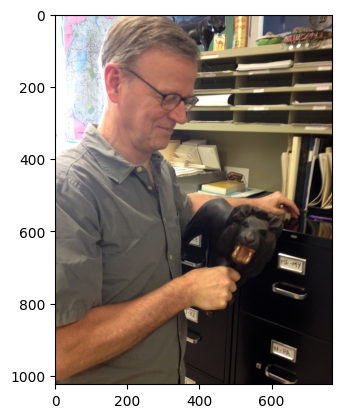

In [6]:
test_imgs_folder = CFG.CUSTOM_DATASET_DIR + 'train/images/'
all_train_imgs = os.listdir(test_imgs_folder)
random_image = random.choice(all_train_imgs)
example_image_path = os.path.join(test_imgs_folder, random_image)
display_image(example_image_path, print_info = True, hide_axis = False)

Visualize many images.

In [7]:
def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED):
    
    random.seed(seed)

    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

    # Ensure that we have at least num_images files to choose from
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

    # Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)

    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        # Open and display the image using PIL
        img = Image.open(os.path.join(folder_path, file_name))
        
        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]
        
        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(file_name)

    # Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()

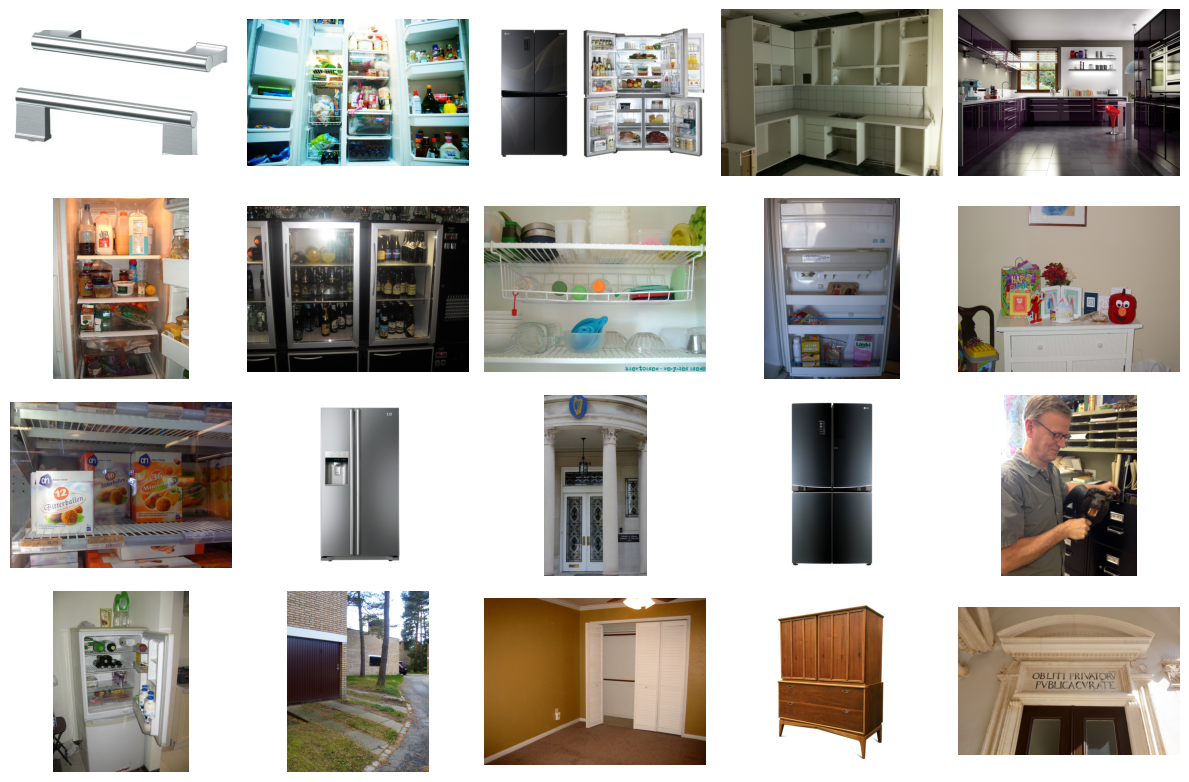

In [8]:
plot_random_images_from_folder(test_imgs_folder, num_images=20, seed=CFG.SEED)

Image properties.

In [9]:
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

In [10]:
img_properties = get_image_properties(example_image_path)
img_properties

{'width': 768, 'height': 1024, 'channels': 3, 'dtype': dtype('uint8')}

Dataset statistics.

In [11]:
class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

    path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
with pd.option_context('display.max_columns', None): 
    display(dataset_stats_df)

,Mode,door,cabinetDoor,refrigeratorDoor,window,chair,table,cabinet,couch,openedDoor,pole,Data_Volume
0,train,309,448,332,187,105,165,138,22,68,14,1008
1,valid,63,99,85,39,24,30,28,1,13,4,230
2,test,25,42,1,49,38,41,44,31,18,3,104


Subplots with statistics of classes.

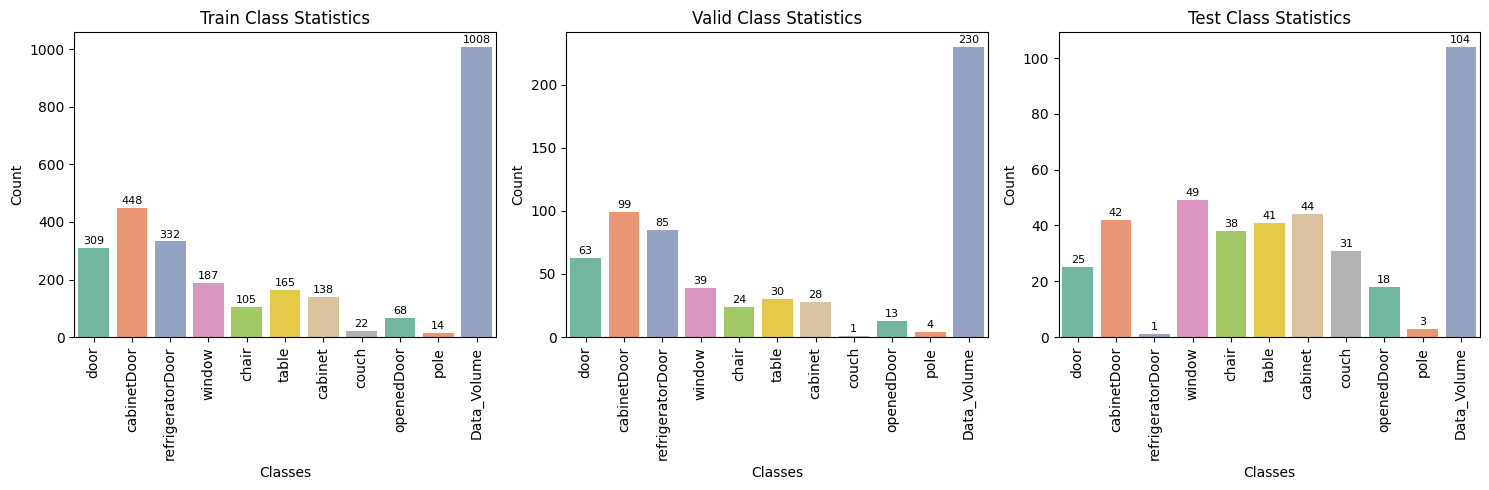

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot vertical bar plots for each mode in subplots
for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(
        data=dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns='Mode'),
        orient='v',
        ax=axes[i],
        palette='Set2'
    )
    
    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90) 

    # Add annotations on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

### 5. YOLO configuration

Create `data.yaml` file properly formatted to be used by Yolo.

In [13]:
dict_file = {
    'train': os.path.join(CFG.CUSTOM_DATASET_DIR, 'train'),
    'val': os.path.join(CFG.CUSTOM_DATASET_DIR, 'valid'),
    'test': os.path.join(CFG.CUSTOM_DATASET_DIR, 'test'),
    'nc': CFG.NUM_CLASSES_TO_TRAIN,
    'names': CFG.CLASSES
    }

with open(os.path.join(CFG.OUTPUT_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

Read yaml file created.

In [14]:
def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

Print yaml file with newlines.

In [15]:
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- door
- cabinetDoor
- refrigeratorDoor
- window
- chair
- table
- cabinet
- couch
- openedDoor
- pole
nc: 10
test: /kaggle/input/indoor-object-detection/test
train: /kaggle/input/indoor-object-detection/train
val: /kaggle/input/indoor-object-detection/valid



Base model interface.

In [16]:
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

100%|██████████| 14.7M/14.7M [00:00<00:00, 133MB/s]


Checking the power of the pretrained model inference on the IOD dataset.

In [17]:
results = model.predict(
    source = example_image_path,

    classes = [0],
    conf = 0.30,
#     device = [0,1], # inference with dual GPU
    device = None, # inference with CPU
    imgsz = (img_properties['height'], img_properties['width']),

    save = True,
    save_txt = True,
    save_conf = True,
    exist_ok = True,
)


image 1/1 /kaggle/input/indoor-object-detection/train/images/0c01e89a58eb20a2.jpg: 1024x768 1 person, 32.2ms
Speed: 8.6ms preprocess, 32.2ms inference, 323.3ms postprocess per image at shape (1, 3, 1024, 768)
Results saved to runs/detect/predict
1 label saved to runs/detect/predict/labels


Check predictions with base model.

Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (1024, 768, 3) 



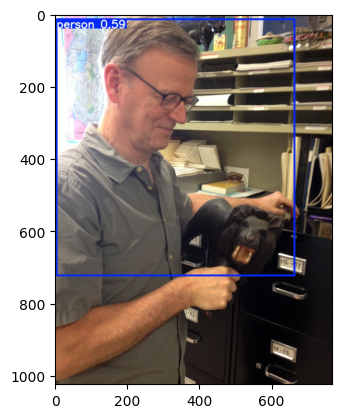

In [18]:
example_image_inference_output = example_image_path.split('/')[-1]
display_image(f'runs/detect/predict/{example_image_inference_output}')

As can be seen from the object detection in a random photo, the untrained YOLO model recognizes a person, but with rather low confidence and not quite the correct contour. The model needs to be further trained on the IOD dataset.

### 6. Model training

Arguments for training.

In [19]:
print('Model: ', CFG.BASE_MODEL_WEIGHTS)
print('Epochs: ', CFG.EPOCHS)
print('Batch: ', CFG.BATCH_SIZE)

Model:  yolov9s.pt
Epochs:  70
Batch:  8


Load pre-trained YOLO model.

In [20]:
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

Training.

In [21]:
%%time

### train
model.train(
    data = os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),

    task = 'detect',

    imgsz = (img_properties['height'], img_properties['width']),

    epochs = CFG.EPOCHS,
    batch = CFG.BATCH_SIZE,
    optimizer = CFG.OPTIMIZER,
    lr0 = CFG.LR,
    lrf = CFG.LR_FACTOR,
    weight_decay = CFG.WEIGHT_DECAY,
    dropout = CFG.DROPOUT,
    fraction = CFG.FRACTION,
    patience = CFG.PATIENCE,
    profile = CFG.PROFILE,
    label_smoothing = CFG.LABEL_SMOOTHING,

    name = f'{CFG.BASE_MODEL}_{CFG.EXP_NAME}',
    seed = CFG.SEED,
    
    val = True,
    amp = True,    
    exist_ok = True,
    resume = False,
    device = [0,1], #  [0] 
#     device = None, # CPU run
    verbose = False,
)

WARNING ⚠️ 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.40 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
                                                 CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov9s.pt, data=/kaggle/working/data.yaml, epochs=70, time=None, patience=20, batch=8, imgsz=(1024, 768), save=True, save_period=-1, cache=False, device=[0, 1], workers=8, project=None, name=yolov9s_ppe_iod_70_epochs, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nm

100%|██████████| 755k/755k [00:00<00:00, 17.5MB/s]
2024-12-03 20:31:30,816	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-12-03 20:31:31,039	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     31104  ultralytics.nn.modules.block.ELAN1           [64, 64, 64, 32]              
  3                  -1  1     73984  ultralytics.nn.modules.block.AConv           [64, 128]                     
  4                  -1  1    258432  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 128, 128, 64, 3]        
  5                  -1  1    221568  ultralytics.nn.modules.block.AConv           [128, 192]                    
  6                  -1  1    579648  ultralytics.nn.modules.block.RepNCSPELAN4    [192, 192, 192, 96, 3]        
  7                  -1  1    442880  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 69.2MB/s]


AMP: checks passed ✅
WARNING ⚠️ updating to 'imgsz=1024'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'


train: Scanning /kaggle/input/indoor-object-detection/train/labels... 1008 images, 120 backgrounds, 0 corrupt: 100%|██████████| 1012/1012 [00:03<00:00, 276.31it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/indoor-object-detection/train is not writeable, cache not saved.


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
train: Scanning /kaggle/input/indoor-object-detection/train/labels... 79 images, 5 backgrounds, 0 corrupt:   8%|▊         | 79/1012 [00:00<00:01, 782.05it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


train: Scanning /kaggle/input/indoor-object-detection/train/labels... 1008 images, 120 backgrounds, 0 corrupt: 100%|██████████| 1012/1012 [00:01<00:00, 828.91it/s]
val: Scanning /kaggle/input/indoor-object-detection/valid/labels... 230 images, 31 backgrounds, 0 corrupt: 100%|██████████| 230/230 [00:00<00:00, 313.73it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/indoor-object-detection/valid is not writeable, cache not saved.


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Plotting labels to runs/detect/yolov9s_ppe_iod_70_epochs/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.0005), 227 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to runs/detect/yolov9s_ppe_iod_70_epochs
Starting training for 70 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/70      3.56G      1.638      3.582      1.779         13       1024: 100%|██████████| 127/127 [00:47<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:05<00:00,  4.98it/s]


                   all        230       1289        0.5      0.257      0.171      0.086

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/70      3.38G      1.505      2.352       1.62          5       1024: 100%|██████████| 127/127 [00:43<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.56it/s]


                   all        230       1289      0.511      0.238      0.183     0.0987

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/70      3.42G      1.557      2.118      1.639         47       1024: 100%|██████████| 127/127 [00:42<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.88it/s]


                   all        230       1289      0.415      0.219      0.177     0.0937

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/70      3.47G      1.519      2.057      1.645         40       1024: 100%|██████████| 127/127 [00:42<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.69it/s]


                   all        230       1289       0.58      0.207      0.195      0.105

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/70      3.42G      1.518      2.052      1.625         18       1024: 100%|██████████| 127/127 [00:42<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.82it/s]


                   all        230       1289      0.535      0.253      0.201      0.112

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/70      3.39G      1.469          2       1.63         47       1024: 100%|██████████| 127/127 [00:42<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.72it/s]


                   all        230       1289      0.442      0.264      0.229      0.125

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/70      3.39G       1.47      1.953      1.626         20       1024: 100%|██████████| 127/127 [00:42<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.89it/s]


                   all        230       1289      0.437      0.244      0.228      0.127

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/70      3.49G      1.466      1.917      1.613         25       1024: 100%|██████████| 127/127 [00:42<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.71it/s]


                   all        230       1289      0.567      0.268      0.246       0.14

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/70      3.39G      1.466      1.942        1.6         22       1024: 100%|██████████| 127/127 [00:42<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.05it/s]


                   all        230       1289       0.55      0.263      0.259      0.141

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/70      3.39G      1.436      1.846      1.577         19       1024: 100%|██████████| 127/127 [00:41<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.91it/s]


                   all        230       1289       0.52      0.287      0.248      0.135

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/70      3.53G      1.451      1.831       1.59         18       1024: 100%|██████████| 127/127 [00:42<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.87it/s]


                   all        230       1289      0.451      0.273      0.252      0.144

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/70       3.4G      1.446       1.73      1.589         19       1024: 100%|██████████| 127/127 [00:42<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.91it/s]


                   all        230       1289      0.575      0.242      0.267      0.147

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/70      3.38G      1.442       1.77      1.578          3       1024: 100%|██████████| 127/127 [00:42<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.91it/s]


                   all        230       1289      0.505      0.298      0.286      0.163

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/70      3.36G      1.389       1.62      1.552         49       1024: 100%|██████████| 127/127 [00:42<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.87it/s]


                   all        230       1289      0.483      0.303      0.276      0.162

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/70       3.4G       1.39      1.714      1.543          6       1024: 100%|██████████| 127/127 [00:42<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.97it/s]


                   all        230       1289      0.521      0.295      0.295      0.169

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/70       3.5G      1.393      1.621      1.522         14       1024: 100%|██████████| 127/127 [00:42<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.93it/s]


                   all        230       1289      0.376      0.323      0.291      0.166

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/70      3.41G      1.392      1.612       1.54         22       1024: 100%|██████████| 127/127 [00:42<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.92it/s]


                   all        230       1289        0.5      0.329       0.31      0.177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/70      3.41G      1.351      1.581      1.534         40       1024: 100%|██████████| 127/127 [00:42<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.84it/s]


                   all        230       1289      0.544      0.309       0.32       0.19

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/70      3.41G      1.329      1.521      1.488          7       1024: 100%|██████████| 127/127 [00:42<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.92it/s]


                   all        230       1289      0.606      0.365      0.344      0.191

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/70      3.42G       1.31      1.489        1.5          7       1024: 100%|██████████| 127/127 [00:42<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.96it/s]


                   all        230       1289      0.633      0.342      0.339      0.197

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/70      3.45G      1.341      1.422      1.506          3       1024: 100%|██████████| 127/127 [00:42<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.02it/s]


                   all        230       1289      0.326      0.386      0.334      0.187

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/70       3.4G      1.289      1.472      1.482         17       1024: 100%|██████████| 127/127 [00:41<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.89it/s]


                   all        230       1289      0.637      0.377       0.39      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/70      3.42G      1.291      1.377      1.462         32       1024: 100%|██████████| 127/127 [00:41<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.04it/s]


                   all        230       1289      0.504      0.338      0.336      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/70       3.4G      1.301      1.394      1.493         25       1024: 100%|██████████| 127/127 [00:41<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.04it/s]


                   all        230       1289      0.348      0.351      0.321      0.185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/70       3.4G      1.311      1.437        1.5          8       1024: 100%|██████████| 127/127 [00:42<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.96it/s]


                   all        230       1289      0.543       0.42      0.346      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/70      3.43G      1.273       1.36      1.469          4       1024: 100%|██████████| 127/127 [00:41<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.01it/s]


                   all        230       1289      0.636      0.294       0.34      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/70       3.4G      1.283      1.351      1.467         19       1024: 100%|██████████| 127/127 [00:42<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.07it/s]


                   all        230       1289      0.347      0.365      0.342      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/70      3.38G      1.309      1.288      1.479         10       1024: 100%|██████████| 127/127 [00:41<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.99it/s]


                   all        230       1289      0.399      0.421      0.389      0.221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/70      3.44G       1.23      1.234      1.422         12       1024: 100%|██████████| 127/127 [00:41<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.11it/s]


                   all        230       1289      0.356      0.399      0.367      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/70      3.39G       1.25      1.226      1.427          9       1024: 100%|██████████| 127/127 [00:41<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.07it/s]


                   all        230       1289      0.376       0.43      0.372      0.214

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/70      3.39G      1.203      1.176      1.403         15       1024: 100%|██████████| 127/127 [00:42<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.07it/s]


                   all        230       1289      0.741      0.312      0.388      0.223

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/70      3.42G      1.212      1.201      1.401         33       1024: 100%|██████████| 127/127 [00:41<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.00it/s]


                   all        230       1289      0.437      0.429      0.397      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/70       3.4G      1.221      1.203      1.435         17       1024: 100%|██████████| 127/127 [00:41<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.98it/s]


                   all        230       1289      0.445      0.473      0.397      0.222

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/70      3.42G      1.207       1.15      1.399         10       1024: 100%|██████████| 127/127 [00:41<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.08it/s]


                   all        230       1289      0.438      0.358      0.367      0.214

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/70       3.4G      1.192      1.114      1.399         37       1024: 100%|██████████| 127/127 [00:42<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.03it/s]


                   all        230       1289      0.417      0.421      0.392      0.227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/70      3.41G      1.199      1.091      1.391         10       1024: 100%|██████████| 127/127 [00:42<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.98it/s]


                   all        230       1289      0.493      0.416      0.364      0.215

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/70      3.41G       1.19      1.134      1.396          7       1024: 100%|██████████| 127/127 [00:42<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.93it/s]


                   all        230       1289      0.449      0.359      0.374      0.221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/70      3.37G      1.179      1.101      1.378         14       1024: 100%|██████████| 127/127 [00:41<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.08it/s]


                   all        230       1289      0.442       0.36      0.378      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/70       3.4G      1.156      1.099      1.387         10       1024: 100%|██████████| 127/127 [00:42<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.09it/s]


                   all        230       1289      0.385      0.465      0.402      0.243

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/70       3.4G      1.159      1.079       1.37         17       1024: 100%|██████████| 127/127 [00:41<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.97it/s]


                   all        230       1289      0.362      0.459       0.38      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/70       3.4G      1.146     0.9979      1.368         26       1024: 100%|██████████| 127/127 [00:42<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.05it/s]


                   all        230       1289      0.538      0.385      0.414      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/70      3.41G      1.153     0.9911      1.364         14       1024: 100%|██████████| 127/127 [00:41<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.96it/s]


                   all        230       1289      0.477      0.422      0.402      0.239

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/70      3.38G      1.148     0.9775      1.357         32       1024: 100%|██████████| 127/127 [00:42<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.07it/s]


                   all        230       1289      0.587      0.469       0.43      0.255

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/70      3.51G      1.145     0.9591      1.353         15       1024: 100%|██████████| 127/127 [00:41<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.03it/s]


                   all        230       1289      0.414      0.421      0.386      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/70      3.39G      1.187      1.024       1.39         22       1024: 100%|██████████| 127/127 [00:42<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.97it/s]


                   all        230       1289      0.463      0.433      0.408      0.248

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/70       3.4G       1.11     0.9142      1.319         16       1024: 100%|██████████| 127/127 [00:41<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.11it/s]


                   all        230       1289      0.552      0.419      0.412      0.245

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/70      3.36G      1.114     0.9616      1.343         18       1024: 100%|██████████| 127/127 [00:42<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.88it/s]


                   all        230       1289      0.489      0.399      0.409      0.237

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/70      3.42G      1.147     0.9332      1.354         22       1024: 100%|██████████| 127/127 [00:41<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.02it/s]


                   all        230       1289      0.433      0.421      0.392      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/70       3.4G      1.095     0.9378      1.314         52       1024: 100%|██████████| 127/127 [00:41<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.99it/s]


                   all        230       1289      0.479      0.369      0.407      0.237

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/70      3.54G      1.114      0.881      1.334          4       1024: 100%|██████████| 127/127 [00:41<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.06it/s]


                   all        230       1289       0.43      0.413      0.407      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/70      3.42G      1.103     0.8951      1.324          8       1024: 100%|██████████| 127/127 [00:41<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.01it/s]


                   all        230       1289      0.516      0.398      0.409      0.247

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/70       3.4G      1.045     0.8579      1.309          8       1024: 100%|██████████| 127/127 [00:41<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.09it/s]


                   all        230       1289      0.504      0.484      0.419      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/70      3.41G      1.055     0.8785      1.288          7       1024: 100%|██████████| 127/127 [00:42<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.99it/s]


                   all        230       1289      0.386      0.401      0.382      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/70      3.47G      1.075     0.8759      1.307         17       1024: 100%|██████████| 127/127 [00:41<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.08it/s]


                   all        230       1289      0.355       0.46      0.405      0.234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/70      3.41G      1.058     0.8186      1.286         14       1024: 100%|██████████| 127/127 [00:42<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.08it/s]


                   all        230       1289      0.422       0.53      0.404      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/70      3.38G      1.059     0.8057      1.288         13       1024: 100%|██████████| 127/127 [00:42<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.05it/s]


                   all        230       1289      0.439      0.539      0.423       0.25

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/70       3.5G      1.035     0.8573      1.297         41       1024: 100%|██████████| 127/127 [00:41<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.07it/s]


                   all        230       1289      0.394      0.512      0.422      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/70      3.44G      1.022     0.8169      1.267         21       1024: 100%|██████████| 127/127 [00:42<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.98it/s]


                   all        230       1289      0.385      0.527      0.411      0.238

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/70       3.4G      1.042     0.7801      1.271         10       1024: 100%|██████████| 127/127 [00:41<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.05it/s]


                   all        230       1289      0.349      0.515      0.398      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/70      3.52G     0.9892     0.7959      1.282         13       1024: 100%|██████████| 127/127 [00:42<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.99it/s]


                   all        230       1289      0.426      0.533       0.43      0.248
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
      61/70      3.41G      1.039     0.7308      1.303          8       1024: 100%|██████████| 127/127 [00:42<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.02it/s]


                   all        230       1289      0.434      0.503      0.453      0.253

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/70      3.39G      1.006     0.7182      1.281          8       1024: 100%|██████████| 127/127 [00:41<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.00it/s]


                   all        230       1289      0.521       0.48      0.456      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/70       3.4G     0.9879     0.6488      1.237         16       1024: 100%|██████████| 127/127 [00:41<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.03it/s]


                   all        230       1289      0.409      0.564      0.498      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/70      3.38G      0.969     0.6268      1.228         17       1024: 100%|██████████| 127/127 [00:41<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.05it/s]


                   all        230       1289      0.481      0.473      0.449      0.249

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/70       3.4G      0.986     0.6569       1.26         32       1024: 100%|██████████| 127/127 [00:41<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.03it/s]


                   all        230       1289      0.464      0.528      0.451       0.25

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/70      3.41G      0.906     0.5721      1.231         22       1024: 100%|██████████| 127/127 [00:41<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.01it/s]


                   all        230       1289      0.568      0.396      0.415      0.241

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/70      3.41G     0.9395     0.6275      1.234         22       1024: 100%|██████████| 127/127 [00:41<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.05it/s]


                   all        230       1289      0.563      0.413      0.453      0.249

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/70      3.39G     0.9664     0.6219      1.253         22       1024: 100%|██████████| 127/127 [00:41<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.02it/s]


                   all        230       1289      0.484      0.535        0.5      0.261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/70       3.4G     0.9429     0.6116      1.225          7       1024: 100%|██████████| 127/127 [00:41<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.11it/s]


                   all        230       1289      0.434      0.564      0.441       0.25

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/70      3.38G     0.9418     0.5963      1.228         12       1024: 100%|██████████| 127/127 [00:41<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.99it/s]


                   all        230       1289      0.424      0.563       0.51      0.269

70 epochs completed in 0.926 hours.
Optimizer stripped from runs/detect/yolov9s_ppe_iod_70_epochs/weights/last.pt, 15.3MB
Optimizer stripped from runs/detect/yolov9s_ppe_iod_70_epochs/weights/best.pt, 15.3MB

Validating runs/detect/yolov9s_ppe_iod_70_epochs/weights/best.pt...
Ultralytics 8.3.40 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
                                                 CUDA:1 (Tesla T4, 15095MiB)
YOLOv9s summary (fused): 486 layers, 7,170,958 parameters, 0 gradients, 26.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.83it/s]


                   all        230       1289      0.419      0.564      0.511      0.269
Speed: 0.4ms preprocess, 11.7ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/yolov9s_ppe_iod_70_epochs
CPU times: user 21.5 s, sys: 4.88 s, total: 26.3 s
Wall time: 56min 25s


Export the model.

In [22]:
model.export(
    format = 'onnx', # openvino, onnx, engine, tflite
    imgsz = (img_properties['height'], img_properties['width']),
    half = False,
    int8 = False,
    simplify = False,
    nms = False,
)

Ultralytics 8.3.40 🚀 Python-3.10.14 torch-2.4.0 CPU (Intel Xeon 2.00GHz)
YOLOv9s summary (fused): 486 layers, 7,170,958 parameters, 0 gradients, 26.7 GFLOPs

PyTorch: starting from 'runs/detect/yolov9s_ppe_iod_70_epochs/weights/best.pt' with input shape (1, 3, 1024, 768) BCHW and output shape(s) (1, 14, 16128) (14.6 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: export success ✅ 1.8s, saved as 'runs/detect/yolov9s_ppe_iod_70_epochs/weights/best.onnx' (27.8 MB)

Export complete (4.6s)
Results saved to /kaggle/working/runs/detect/yolov9s_ppe_iod_70_epochs/weights
Predict:         yolo predict task=detect model=runs/detect/yolov9s_ppe_iod_70_epochs/weights/best.onnx imgsz=1024,768  
Validate:        yolo val task=detect model=runs/detect/yolov9s_ppe_iod_70_epochs/weights/best.onnx imgsz=1024,768 data=/kaggle/working/data.yaml  WARNING ⚠️ non-PyTorch val requires square images, 'imgsz=[1024, 768]' will not work. Use export 'imgsz=1024' if val is required.
Visualize:       ht

'runs/detect/yolov9s_ppe_iod_70_epochs/weights/best.onnx'

### 7. Results analysis

Train results.

In [23]:
results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'batch' not in i
]

results_paths

['/kaggle/working/runs/detect/yolov9s_ppe_iod_70_epochs/R_curve.png',
 '/kaggle/working/runs/detect/yolov9s_ppe_iod_70_epochs/P_curve.png',
 '/kaggle/working/runs/detect/yolov9s_ppe_iod_70_epochs/PR_curve.png',
 '/kaggle/working/runs/detect/yolov9s_ppe_iod_70_epochs/confusion_matrix.png',
 '/kaggle/working/runs/detect/yolov9s_ppe_iod_70_epochs/confusion_matrix_normalized.png',
 '/kaggle/working/runs/detect/yolov9s_ppe_iod_70_epochs/results.png',
 '/kaggle/working/runs/detect/yolov9s_ppe_iod_70_epochs/F1_curve.png',
 '/kaggle/working/runs/detect/yolov9s_ppe_iod_70_epochs/labels.jpg',
 '/kaggle/working/runs/detect/yolov9s_ppe_iod_70_epochs/labels_correlogram.jpg']

Visualization of learning curves and confusion matrix.

/kaggle/working/runs/detect/yolov9s_ppe_iod_70_epochs/F1_curve.png


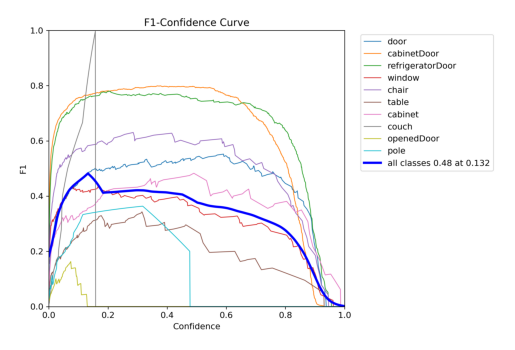



/kaggle/working/runs/detect/yolov9s_ppe_iod_70_epochs/PR_curve.png


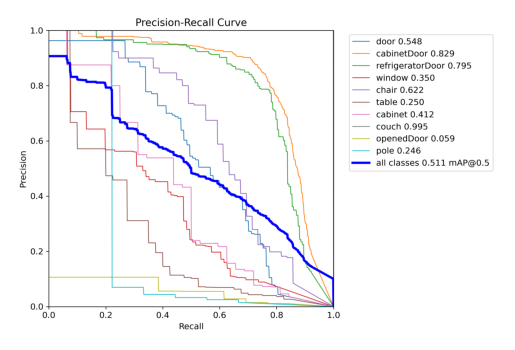



/kaggle/working/runs/detect/yolov9s_ppe_iod_70_epochs/P_curve.png


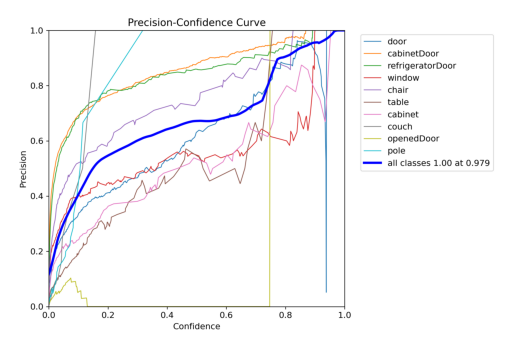



/kaggle/working/runs/detect/yolov9s_ppe_iod_70_epochs/R_curve.png


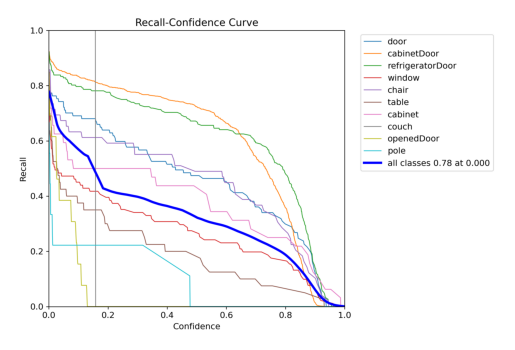



/kaggle/working/runs/detect/yolov9s_ppe_iod_70_epochs/confusion_matrix.png


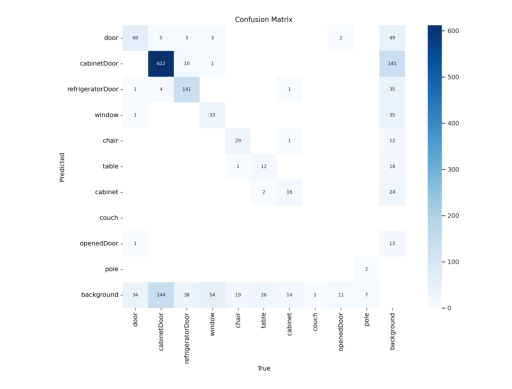



/kaggle/working/runs/detect/yolov9s_ppe_iod_70_epochs/confusion_matrix_normalized.png


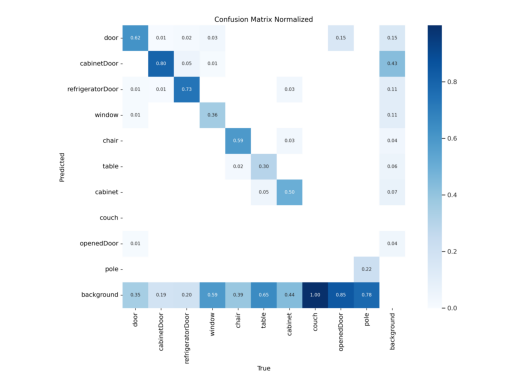



/kaggle/working/runs/detect/yolov9s_ppe_iod_70_epochs/labels.jpg


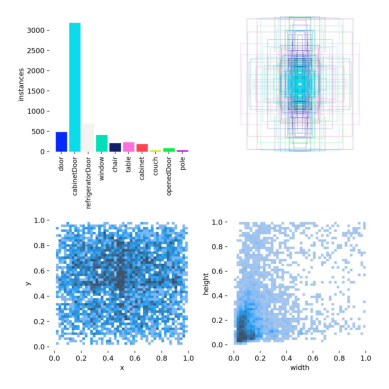



/kaggle/working/runs/detect/yolov9s_ppe_iod_70_epochs/labels_correlogram.jpg


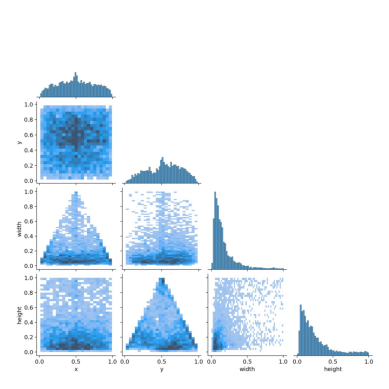



/kaggle/working/runs/detect/yolov9s_ppe_iod_70_epochs/results.png


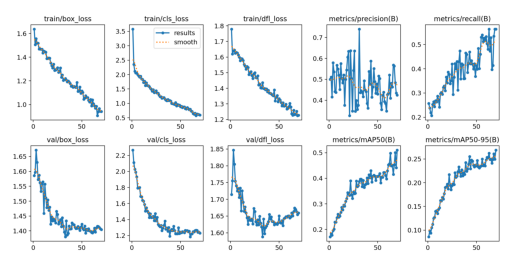

In [24]:
for file in sorted(results_paths):
    print(file)
    display_image(file, print_info = False, hide_axis = True)
    print('\n')

Loss

* The loss function in YOLO consists of three main components: box loss, class loss (cls loss), and objectness loss (dfl loss).
* The total loss in YOLO is a combination of these three components
---
**Box loss:**

* The box loss measures how accurately the predicted bounding box coordinates match the ground truth bounding box.
* Is typically computed using a regression loss, such as Mean Squared Error (MSE), between the predicted bounding box coordinates (center coordinates, width, and height) and the ground truth bounding box coordinates.
---
**Class loss (cls):**

* The class loss measures how well the predicted class probabilities match the true class labels.
* The class loss is usually computed using a categorical cross-entropy loss, which penalizes the difference between the predicted class probabilities and the true class labels.
---
**Objectness loss (dfl):**

* Distribution Focal Loss
* YOLO predicts an "objectness" score for each bounding box, indicating the presence of an object within the grid cell. This score helps filter out irrelevant bounding boxes.
* The objectness loss is calculated based on the difference between the predicted objectness score and the ground truth objectness label. It penalizes the model for false positives and false negatives in predicting the presence of an object.

In [25]:
df = pd.read_csv(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/results.csv')
df = df.rename(columns=lambda x: x.replace(" ", ""))
df.to_csv(f'{CFG.OUTPUT_DIR}training_log_df.csv', index=False)
df

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,63.1627,1.63760,3.58177,1.77945,0.50040,0.25698,0.17116,0.08597,1.58584,2.26639,1.71400,0.000236,0.000236,0.000236
1,2,112.5690,1.50530,2.35240,1.61951,0.51103,0.23837,0.18300,0.09873,1.59715,2.11069,1.75502,0.000467,0.000467,0.000467
2,3,160.7230,1.55682,2.11833,1.63936,0.41540,0.21851,0.17711,0.09370,1.67158,2.02819,1.84671,0.000692,0.000692,0.000692
3,4,208.4020,1.51935,2.05749,1.64482,0.57982,0.20657,0.19495,0.10493,1.63019,1.99192,1.80487,0.000684,0.000684,0.000684
4,5,256.1130,1.51829,2.05229,1.62465,0.53533,0.25268,0.20131,0.11195,1.57246,1.93206,1.75385,0.000674,0.000674,0.000674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,66,3145.3200,0.90602,0.57213,1.23137,0.56844,0.39636,0.41502,0.24099,1.41573,1.26753,1.67401,0.000058,0.000058,0.000058
66,67,3192.1600,0.93951,0.62745,1.23445,0.56327,0.41337,0.45264,0.24918,1.41480,1.26393,1.66974,0.000048,0.000048,0.000048
67,68,3238.8700,0.96640,0.62194,1.25312,0.48428,0.53453,0.50041,0.26086,1.41139,1.24133,1.66260,0.000037,0.000037,0.000037
68,69,3285.4500,0.94288,0.61160,1.22465,0.43445,0.56375,0.44104,0.24972,1.40739,1.24371,1.65448,0.000027,0.000027,0.000027


In [26]:
print('*'*50)
print('\nBest Training Box loss: ', df['train/box_loss'].min(), ', on epoch: ', df['train/box_loss'].argmin() + 1, '\n')
print('\nBest Validation Box loss: ', df['val/box_loss'].min(), ', on epoch: ', df['val/box_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training Cls loss: ', df['train/cls_loss'].min(), ', on epoch: ', df['train/cls_loss'].argmin() + 1, '\n')
print('\nBest Validation Cls loss: ', df['val/cls_loss'].min(), ', on epoch: ', df['val/cls_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training DFL loss: ', df['train/dfl_loss'].min(), ', on epoch: ', df['train/dfl_loss'].argmin() + 1, '\n')
print('\nBest Validation DFL loss: ', df['val/dfl_loss'].min(), ', on epoch: ', df['val/dfl_loss'].argmin() + 1, '\n')

**************************************************

Best Training Box loss:  0.90602 , on epoch:  66 


Best Validation Box loss:  1.38028 , on epoch:  33 


Best Training Cls loss:  0.57213 , on epoch:  66 


Best Validation Cls loss:  1.18516 , on epoch:  60 


Best Training DFL loss:  1.22465 , on epoch:  69 


Best Validation DFL loss:  1.58818 , on epoch:  33 



Loss curves.

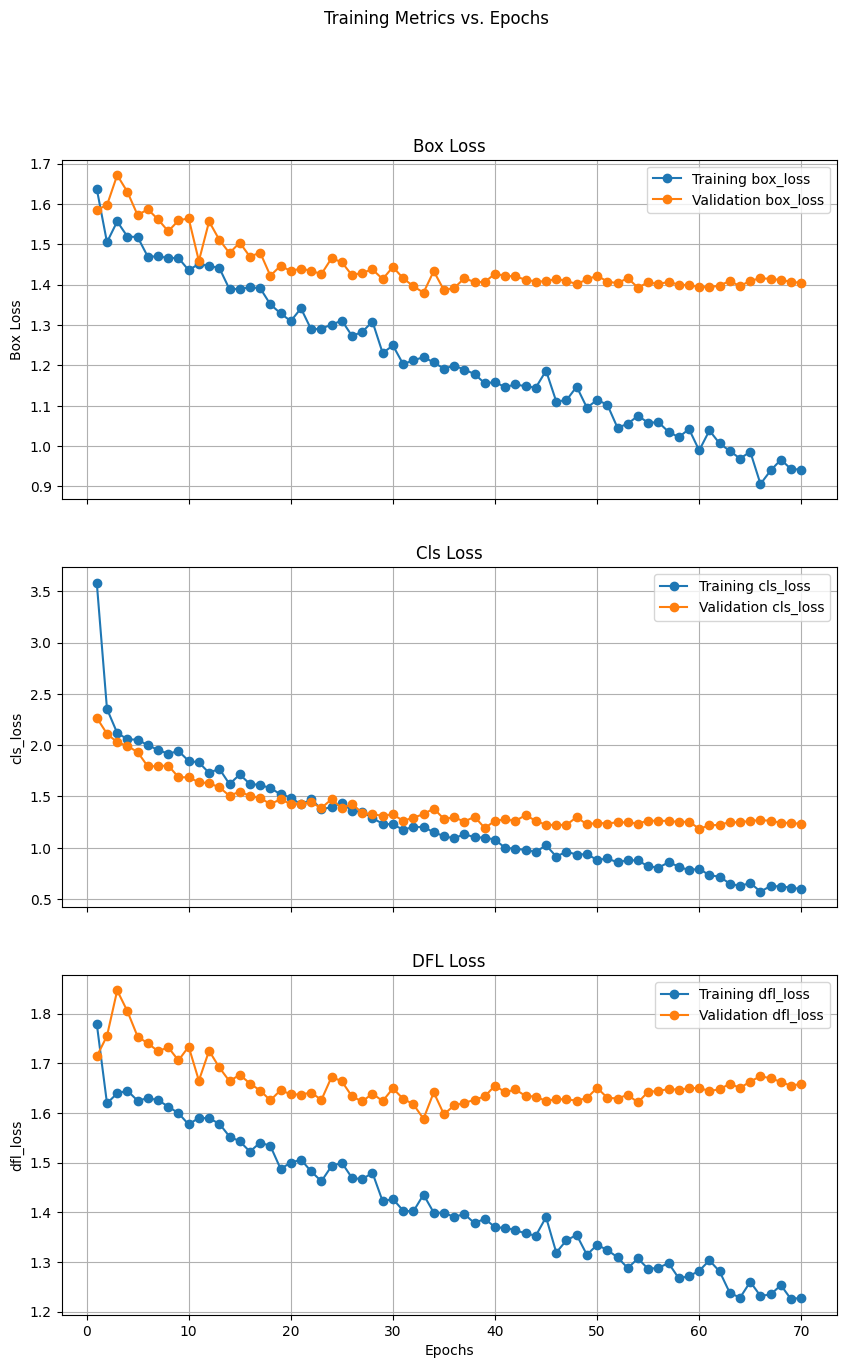

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

### Training and Validation box_loss
ax1.set_title('Box Loss')
ax1.plot(df['epoch'], df['train/box_loss'], label='Training box_loss', marker='o', linestyle='-')
ax1.plot(df['epoch'], df['val/box_loss'], label='Validation box_loss', marker='o', linestyle='-')
ax1.set_ylabel('Box Loss')
ax1.legend()
ax1.grid(True)

### Training and Validation cls_loss
ax2.set_title('Cls Loss')
ax2.plot(df['epoch'], df['train/cls_loss'], label='Training cls_loss', marker='o', linestyle='-')
ax2.plot(df['epoch'], df['val/cls_loss'], label='Validation cls_loss', marker='o', linestyle='-')
ax2.set_ylabel('cls_loss')
ax2.legend()
ax2.grid(True)

### Training and Validation dfl_loss
ax3.set_title('DFL Loss')
ax3.plot(df['epoch'], df['train/dfl_loss'], label='Training dfl_loss', marker='o', linestyle='-')
ax3.plot(df['epoch'], df['val/dfl_loss'], label='Validation dfl_loss', marker='o', linestyle='-')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('dfl_loss')
ax3.legend()
ax3.grid(True)

plt.suptitle('Training Metrics vs. Epochs')
plt.show()

Validation results.

In [28]:
validation_results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'val_batch' in i
]

len(validation_results_paths)

6

In [29]:
if len(validation_results_paths) >= 1:
    print(validation_results_paths[-1])

/kaggle/working/runs/detect/yolov9s_ppe_iod_70_epochs/val_batch1_pred.jpg


Check predictions or labels from a random validation batch.

/kaggle/working/runs/detect/yolov9s_ppe_iod_70_epochs/val_batch1_pred.jpg


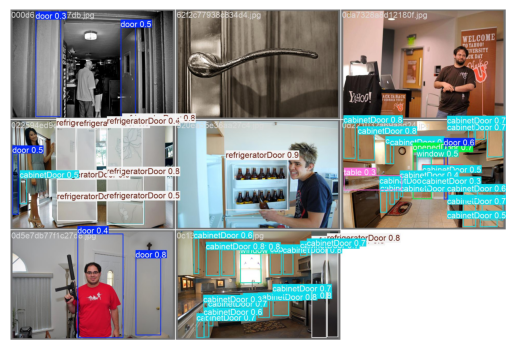

In [ ]:
if len(validation_results_paths) >= 1:
    val_img_path = random.choice(validation_results_paths)
    print(val_img_path)
    display_image(val_img_path, print_info = False, hide_axis = True)

### Conclusions:

From the analysis of learning curves and confusion matrix, the following conclusions can be drawn.

#### Analysis of learning curves:
* After epoch 33, the model started to show signs of overfitting. Given that the training dataset only has about 1000 images, it is possible to apply data augmentation and add dropouts to the model itself to address this issue.
* mAP@50 досягає значення 51%, що є доволі низьким показником. Отже, баланс Precision і Recall на простих випадках дає посередню точність.
* Also, mAP@50-95 at 27% makes it clear that the model needs further improvement, since only at low threshold levels do we have correct detections.

#### Model performance analysis for each class:
* During training, the overal Recall gradually increases to 60%, while the Precision fluctuates around 50% (the best Precision value is 74% with a Recall of 31% that is, the model simply misses a large number of objects), which indicates an insufficient amount of data for the model to capture the most important features necessary for classifying a given data set.
* The model maximizes f1-score to 0.48 for all classes at a threshold of 0.132.
* The model performed best in recognizing refrigerator dorrs and cabinet doors (f1-score reaches 80% in the confidence interval from 20% to 70%). The model coped worse with the separation of chairs, doors, windows and cabinets, f1 for them fluctuates between 40-60%. The model did not cope at all with recognizing couches, opened doors, poles, and tables, which is due to the small number of samples of these classes in this data set.

#### Analysis of confusion matrix:
* In this dataset, there are a large number of different door classes, and the background contains a significant number of rectangular objects. This explains why the model confused different door classes with each other, and also attributed the background to doors and vice versa.

#### Recommendations:
* During the task, mediocre accuracy of object detection in images was achieved, which is in no way suitable for product application of the model.
* The main reason for the mediocre result is the small size of the training dataset in general and too few objects of certain classes in the photo in particular. To improve the model, data augmentation is needed, especially for underrepresented classes. It's also possible experimenting with the size of the batches and dropouts to prevent overfitting and increase the number of training epochs.